In [68]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [69]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
image_pixels = 28
kernel = 5

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [70]:
sess = tf.InteractiveSession()

In [71]:
def weight_initialise(shape):
    value = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(value)

def bias_initialise(shape):
    value = tf.constant(0.1, shape=shape)
    return tf.Variable(value)


In [72]:
x = tf.placeholder(tf.float32, shape=[None, 784])
targets = tf.placeholder(tf.float32, shape=[None, 10])

In [73]:
#cnn
input_layer = tf.reshape(x, [-1, image_pixels, image_pixels, 1])

params_conv1 = weight_initialise([kernel, kernel, 1, 32])
bias_conv1 = bias_initialise([32])
output_conv1 = tf.nn.relu(tf.nn.conv2d(input_layer, params_conv1, strides=[1, 1, 1, 1], padding='SAME')+bias_conv1)
pool_conv1 = tf.nn.max_pool(output_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

params_conv2 = weight_initialise([kernel, kernel, 32, 64])
bias_conv2 = bias_initialise([64])
output_conv2 = tf.nn.relu(tf.nn.conv2d(pool_conv1, params_conv2, strides=[1, 1, 1, 1], padding='SAME')+bias_conv2)
pool_conv2 = tf.nn.max_pool(output_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

params_fc1 = weight_initialise([7*7*64, 1024])
bias_fc1 = bias_initialise([1024])

pool_conv2_flat = tf.reshape(pool_conv2, [-1, 7*7*64])

output_fc1 = tf.nn.relu(tf.matmul(pool_conv2_flat, params_fc1) + bias_fc1)

keep_prob = tf.placeholder(tf.float32)
dropout = tf.nn.dropout(output_fc1, keep_prob)

params_fc2 = weight_initialise([1024, 10])
bias_fc2 = bias_initialise([10])
y_conv = tf.matmul(dropout, params_fc2) + bias_fc2

In [74]:
y = tf.nn.softmax(y_conv)

In [75]:
# Loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)
train = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

In [76]:
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(targets,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [77]:
sess.run(tf.global_variables_initializer())

In [83]:
# Train model
for i in range(1000):
    batch_x, batch_y = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, targets: batch_y, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train.run(feed_dict={x: batch_x, targets: batch_y, keep_prob: 0.5})

step 0, training accuracy 0.11
step 200, training accuracy 0.89
step 400, training accuracy 0.96
step 600, training accuracy 0.96
step 800, training accuracy 0.99


In [84]:
# Test model
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:500], 
                                                  targets: mnist.test.labels[0:500], keep_prob: 1.0}))

test accuracy 0.984


In [85]:
def plot_predictions(image_list):
   
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.5)
    
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) 
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        if (i % 3 == 1): 
            grid[i].set_title("Noise")
        
    plt.show()
    
    return prob 

In [105]:
def create_plot_adversarial_images(x_image, y_label, n_steps=1):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    grad = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x-tf.sign(grad)*0.04)
    image_adv = tf.clip_by_value(image_adv, 0, 1) 
    
    for i in range(n_steps):
        dydx = sess.run(grad, {x: x_image, keep_prob: 1.0}) 
        x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
    
        x_image = np.reshape(x_adv, (1, 784))
        img_adv_list = original_image
        img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
        img_adv_list = np.append(img_adv_list, x_image, axis=0)
        
        probs = plot_predictions(img_adv_list)
        probs_per_step.append(probs) 

In [106]:
# Pick a random image from first 1000 images 
# Create adversarial image with target label 3
rand_index = np.random.randint(0,1000)
image_normal = mnist.test.images[rand_index]
image_normal= np.reshape(image_normal, (1, 784))
label_adv = [0,0,0,1,0,0,0,0,0,0] 

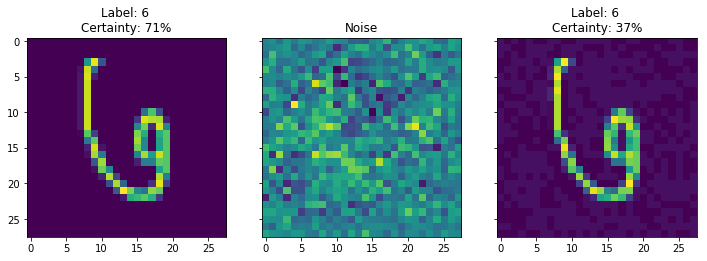

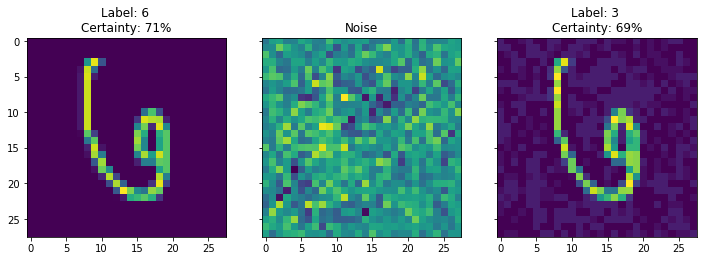

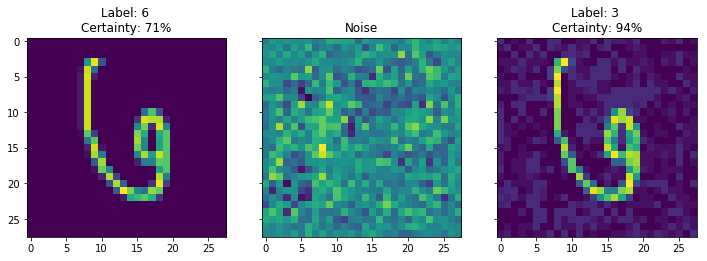

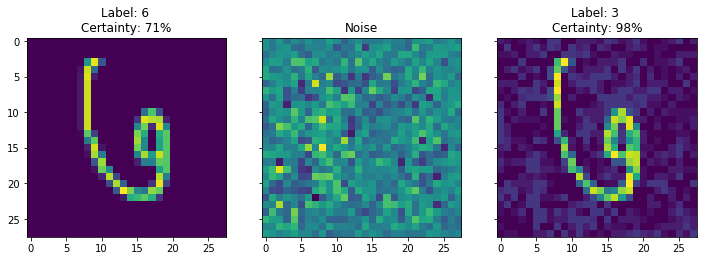

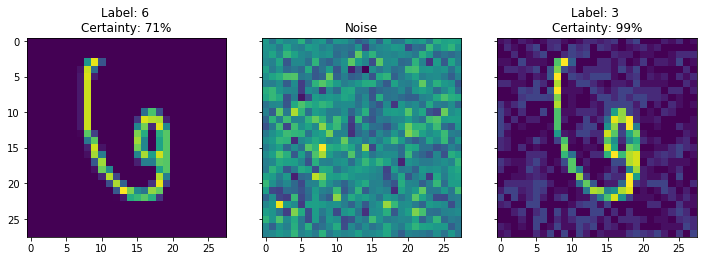

In [107]:
# Plot adversarial images
create_plot_adversarial_images(image_normal, label_adv, n_steps=5)